In [1]:
import tweepy
import pandas as pd
import authentification
import datetime

In [2]:
screen_name = "1O17SQD"
TWEET_MODE = 'extended'
api = authentification.credentials()

def get_tweets(screen_name, api):
    """
    Retrieves tweets from the specified user using the specified Twitter API.

    Parameters
    ----------
    screen_name : str
        Screen name of the user whose tweets are to be retrieved.
    api: tweepy.API
        Twitter API object used to access the user's tweets.

    Returns
    -------
    list of tweepy.models.Status
        List of the user's tweets.
    """
    tweets = api.user_timeline(screen_name=screen_name,
                               # 200 is the maximum number allowed
                               count=200,
                               exclude_replies=False,
                               include_rts=False,
                               # Necessary to keep the full text
                               # otherwise only the first 140 words are extracted
                               tweet_mode=TWEET_MODE
                               )
    return tweets

def get_all_tweets(screen_name, api):
    """
    Retrieves all tweets from the specified user using the specified Twitter API.

    Parameters
    ----------
    screen_name : str
        Screen name of the user whose tweets are to be retrieved.
    api: tweepy.API
        Twitter API object used to access the user's tweets.

    Returns
    -------
    list of tweepy.models.Status
        List of all the user's tweets.
    """
    tweets = get_tweets(screen_name, api)
    all_tweets = []
    all_tweets.extend(tweets)
    oldest_id = tweets[-1].id
    while True:
        tweets = api.user_timeline(screen_name=screen_name,
                                   # 200 is the maximum number allowed
                                   count=200,
                                   exclude_replies=False,
                                   include_rts=False,
                                   max_id=oldest_id - 1,
                                   # Necessary to keep the full text
                                   # otherwise only the first 140 words are extracted
                                   tweet_mode=TWEET_MODE
                                   )
        if not len(tweets):
            break
        oldest_id = tweets[-1].id
        all_tweets.extend(tweets)

    return all_tweets

In [3]:
import re
import unicodedata
from nltk.tokenize import WordPunctTokenizer

In [4]:
def cleaning_tweets(tweets):
    """
    Clean up a tweet by removing links, hashtags, mentions and emoticons.

    Parameters
    ----------
    tweet : str
        Tweet to clean up.

    Returns
    -------
    str
        Tweet cleaned up.
    """
    regex_pattern = re.compile(pattern="["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictograms
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    pattern = re.compile(r'(https?://)?(www\.)?(\w+\.)?(\w+)(\.\w+)(/.+)?')
    tweets = re.sub(regex_pattern, '', tweets)  # replaces the pattern with ''
    tweets = re.sub(pattern, '', tweets)
    tweets = re.sub(r'@[^\s]+', '', tweets)
    tweets = re.sub(r'#[^\s]+', '', tweets)
    # Removes special characters and links
    #tweets = re.sub(r'[^\w\s]', '', tweets)
    tweets = re.sub(r'https?://[A-Za-z0-9./]+', '', tweets)
    # Removes user mentions
    tweets = re.sub(r'@[A-Za-z0-9]+', '', tweets)

    token = WordPunctTokenizer()
    words = token.tokenize(tweets)
    result_words = [x for x in words]
    return " ".join(result_words)

def remove_emojis(tweets):
    text = cleaning_tweets(tweets)
    # Create an empty list to store the cleaned text
    cleaned_text = []

    # Scroll through each character of the text
    for character in text:
        # Use the `category` function of the `unicodedata` library to get the Unicode category of the character
        character_category = unicodedata.category(character)
        # If the character's Unicode category is not "So" (Symbol, Other), add the character to the clean text list
        if character_category != "So":
            cleaned_text.append(character)

    # Join the characters in the cleaned text list into a string and return it
    return "".join(cleaned_text)

In [5]:
def process_tweets(tweets):
    """
    Processes tweets by removing empty words.

    Parameters
    ----------
    tweets : list of str
        List of tweets to process.

    Returns
    -------
    list of str
        List of processed tweets.
    """
    with open("french_stopwords.txt", "r", encoding="utf-8") as stopwords_file:
        stopwords = []
        for line in stopwords_file:
            word = line.split("|")[0].strip()
            stopwords.append(word)

    cleaned_tweets = []
    for tweet in tweets.lower().split():
        if (tweet not in stopwords) and (len(tweet) > 1):
            cleaned_tweets.append(remove_emojis(tweet))
                      
    return cleaned_tweets

In [11]:
from vaderSentiment_fr.vaderSentiment import SentimentIntensityAnalyzer
# Function for polarity score
def polarity_score(tweet):
    SIA = SentimentIntensityAnalyzer()
    return SIA.polarity_scores(tweet)['compound']

# Function to get sentiment type
def sentimentvader(tweet):
    polarity = polarity_score(tweet)
    if polarity < 0:
        return "Négatif"
    elif polarity == 0:
        return "Neutre"
    else:
        return "Positif"

In [13]:
def public_metrics(screen_name, api):
    tweet_source = []
    year = []
    year_month = []
    tweets_txt = []
    nb_retweet = []
    nb_fav = []
    
    for status in get_all_tweets(screen_name, api):
        tweet_source.append(status.source)
        year.append(int(status.created_at.strftime("%Y")))
        year_month.append(status.created_at.strftime("%Y-%m"))
        tweets_txt.append(status.full_text)
        nb_retweet.append(status.retweet_count)
        nb_fav.append(status.favorite_count)
        
    dict_metrics = {'tweet_source': tweet_source, 'year': year,
          'tweets_txt':tweets_txt, 'nb_retweet':nb_retweet,
          'nb_favorite':nb_fav, 'year_month':year_month}
    
    df_metrics = pd.DataFrame(dict_metrics)
    return df_metrics

df = public_metrics(screen_name, api)

In [37]:
from textblob import TextBlob
from textblob_fr import PatternTagger, PatternAnalyzer
def blob_polarity(tweet):
    return TextBlob(tweet, pos_tagger=PatternTagger(), analyzer=PatternAnalyzer()).sentiment[0]

def sentimentblob(tweet):
    polarity = blob_polarity(tweet)
    if polarity < 0:
        return "Négatif"
    elif polarity == 0:
        return "Neutre"
    else:
        return "Positif"

In [46]:
sentences[0]

'Apple cherche à acheter une start-up anglaise pour 1 milliard de dollars'

In [49]:
import spacy
from spacy.lang.fr.examples import sentences 
from spacytextblob.spacytextblob import SpacyTextBlob

nlp = spacy.load('fr_dep_news_trf')
nlp.add_pipe('spacytextblob')

doc = nlp(sentences[0])
print(doc.text)
for token in doc:
    print(token.text, token.polarity)

In [42]:
pos, neg, neu = '', '', ''
for mot in process_tweets(remove_emojis(' '.join(df['tweets_txt']))):
    sent = sentimentvader(mot)
    if sent == 'Positif':
        pos+= mot + ' '
    elif sent == 'Négatif':
        neg+= mot + ' '
    else:
        neu+= mot + ' '

In [44]:
neg

'putain foutre péché peur mourir déprime simple envie :( :( traîner envie déteste étrange arrêter lutter douleur méchants douleurs mal bête oublier honteux honte sombre tue obligé con mort ... '

In [55]:
# using the functions to get the polarity and sentiment
df['polarity'] = df['tweets_txt'].apply(polarity)
df['sentiment'] = df['polarity'].apply(sentimenttextblob)

KeyboardInterrupt: 

In [ ]:
df

In [9]:
# using the functions to get the polarity and sentiment
df['polarity'] = df['tweets_txt'].apply(polarity)
df['sentiment'] = df['polarity'].apply(sentimenttextblob)

In [15]:
df[(df["year"] >= 2020) & (df["year"] <= 2023) & (df["sentiment"] == "Négatif")].tweets_txt

0       je pense qu'on ne m'aime pas, mais je ne suis ...
1       Chat GPT, Google Bard… : l’intelligence artifi...
4       j'ai perdu l'habitude d'aller au cinéma tous l...
5       je ne suis pas sûr d’avoir mangé aujourd’hui e...
9       il est approximativement 04:30, je suis en tra...
                              ...                        
1036    @mshbrst moi qui pensais être anormal en rêvan...
1041    @Symeonbt ça correspond pas totalement à ce qu...
1043                      @Symeonbt ça se voit c'est faux
1045    j'aime trop me faire du mal en regardant les a...
1046      cette scène en dit long https://t.co/E3kqVFSZ7p
Name: tweets_txt, Length: 250, dtype: object

In [49]:
' '.join(list(df[(df["year"] >= 2020) & (df["year"] <= 2023)].tweets_txt))

'je pense qu\'on ne m\'aime pas, mais je ne suis pas sûr 🤣 https://t.co/dk5WPoK9J1 Chat GPT, Google Bard… : l’intelligence artificielle va-t-elle nous remp... https://t.co/PrWWCjaZKN j\'ai drop quelques projets sur mon github, dans mes langues les plus utilisées j\'ai 70% de CSS 🙄 https://t.co/4UIVtJrAUQ j\'ai regardé inception lors d\'un déplacement pro, j\'ai dû mettre pause plusieurs fois, ce qui est assez chiant, je veux le regarder en one shot ! j\'ai perdu l\'habitude d\'aller au cinéma tous les dimanches soir je ne suis pas sûr d’avoir mangé aujourd’hui et j’y pense seulement maintenant 😔 bien sûr, pourquoi pas tant qu’on y est, trouvons des excuses au racisme https://t.co/j6zsy2uQVp je considère que "se nourrir" n’est pas un fait intéressant, si cela ne tenait qu’à moi, ce serait optionnel je suis en train de me demander depuis tout à l\'heure pourquoi je crève de faim, alors qu\'en fait, il est bientôt 22h et je n\'ai toujours rien mangé  😓 il est approximativement 04:30, je s

In [92]:
res = " ".join(process_tweets(remove_emojis(' '.join(list(df[(df["year"] >= 2017) & (df["year"] <= 2023) & (df["sentiment"] == "Neutre")].tweets_txt)))))

In [86]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

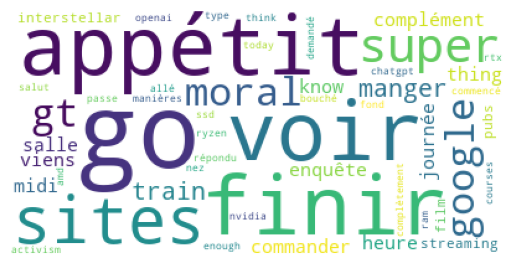

In [94]:
wordcloud = WordCloud(background_color = 'white', max_words = 50).generate(res)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [119]:
from textblob import TextBlob
def processing(text):
    return TextBlob(text).words

'je pense qu\'on ne m\'aime pas, mais je ne suis pas sûr 🤣 https://t.co/dk5WPoK9J1 Chat GPT, Google Bard… : l’intelligence artificielle va-t-elle nous remp... https://t.co/PrWWCjaZKN j\'ai drop quelques projets sur mon github, dans mes langues les plus utilisées j\'ai 70% de CSS 🙄 https://t.co/4UIVtJrAUQ j\'ai regardé inception lors d\'un déplacement pro, j\'ai dû mettre pause plusieurs fois, ce qui est assez chiant, je veux le regarder en one shot ! j\'ai perdu l\'habitude d\'aller au cinéma tous les dimanches soir je ne suis pas sûr d’avoir mangé aujourd’hui et j’y pense seulement maintenant 😔 bien sûr, pourquoi pas tant qu’on y est, trouvons des excuses au racisme https://t.co/j6zsy2uQVp je considère que "se nourrir" n’est pas un fait intéressant, si cela ne tenait qu’à moi, ce serait optionnel je suis en train de me demander depuis tout à l\'heure pourquoi je crève de faim, alors qu\'en fait, il est bientôt 22h et je n\'ai toujours rien mangé  😓 il est approximativement 04:30, je s

In [121]:
exclure_mots = ['d', 'du', 'de', 'la', 'des', 'le', 'et', 'est', 'elle', 'une', 'en', 'que', 'aux', 'qui', 'ces', 'les', 'dans', 'sur', 'l', 'un', 'pour', 'par', 'il', 'ou', 'à', 'ce', 'a', 'sont', 'cas', 'plus', 'leur', 'se', 's', 'vous', 'au', 'c', 'aussi', 'toutes', 'autre', 'comme']
wordcloud = WordCloud(background_color = 'white', stopwords = exclure_mots, max_words = 50).generate(TextBlob(" ".join(df['tweets_txt'])).words)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

TypeError: expected string or bytes-like object